# Enhanced SBI Simulator - Prior Demonstration

This notebook demonstrates the new prior functionality in the enhanced SBI simulator, including:
- Custom flat prior implementation
- Background parameter integration
- Prior visualization tools
- Parameter exploration

In [2]:
import sys
import os
sys.path.append('..')

import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns

from multiplex_sim.sbi_simulator_with_filters import (
    EnhancedSBISimulator, 
    EnhancedSBIConfig, 
    create_enhanced_sbi_simulator,
    CustomFlatPrior
)
from multiplex_sim.prior_visualization import PriorVisualizer

/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Setup Enhanced Simulator with Background Parameters

In [3]:
EnhancedSBIConfig?

Init signature:
EnhancedSBIConfig(
    wavelength_range: Tuple[int, int] = (500, 800),
    wavelength_step: float = 1.0,
    total_dye_photons: float = 300.0,
    total_background_photons: float = 30.0,
    filter_type: str = 'sigmoid',
    edge_steepness: float = 1.0,
    background_fluorophore: str = 'NADH',
    excitation_wavelengths: Optional[List[float]] = None,
    optimize_excitation: bool = True,
    excitation_search_range: float = 30.0,
    include_excitation_crosstalk: bool = True,
    excitation_power_budget: float = 1.0,
    random_seed: int = 42,
    center_wavelength_bounds: Tuple[float, float] = (500, 800),
    bandwidth_bounds: Tuple[float, float] = (10, 50),
    min_wavelength_separation: float = 10.0,
    center_wavelength_distribution: str = 'uniform',
    peak_centered_std: float = 10.0,
    n_channels: int = 5,
    include_filter_params: bool = True,
    include_background_params: bool = False,
    background_bounds: Tuple[float, float] = (1.0, 200.0),
) -> None
D

In [6]:
# Configure enhanced simulator
config = EnhancedSBIConfig(
    n_channels=8,
    include_filter_params=True,
    center_wavelength_distribution='tile_peaks',  # Options: 'peak_centered', 'uniform'
    bandwidth_bounds=(10, 50),
    include_background_params=True,
    background_bounds=(10.0, 100.0),
    peak_centered_std=20.0
)

# Create simulator
fluorophore_names = ['JF479','JF525', 'JF552', 'JF608', 'JFX650','JFX673']
simulator = create_enhanced_sbi_simulator(
    spectra_dir="../data/spectra_npz",    fluorophore_names=fluorophore_names,
    config=config
)

print(f"Simulator created with {len(fluorophore_names)} fluorophores")
print(f"Total parameters: {simulator.total_params}")
print(f"Concentration params: {simulator.n_concentration_params}")
print(f"Filter params: {simulator.n_filter_params}")
print(f"Background params: {simulator.config.background_fluorophore}")

ADVANCED EXCITATION WAVELENGTH OPTIMIZATION
Fluorophores: JF479, JF525, JF552, JF608, JFX650, JFX673
Search range: ±30.0 nm around peaks
Min separation: 10.0 nm
Running multi-start optimization with 5 starts...
  Start 1/5... Success (cost: -1.8597)
  Start 2/5... Success (cost: -1.8597)
  Start 3/5... Success (cost: -1.8597)
  Start 4/5... Success (cost: -1.8597)
  Start 5/5... Success (cost: -1.8597)
Optimization completed in 21.65 seconds

Optimization Results:
Success rate: 5/5
Best cost: -1.8597
Optimization time: 21.65s

Optimal Excitation Wavelengths:
  JF479: 470 nm
  JF525: 520 nm
  JF552: 554 nm
  JF608: 603 nm
  JFX650: 646 nm
  JFX673: 681 nm

Validation Metrics:
  Signal strength: 5.599
  Crosstalk penalty: 1.870
  Detection separability: 0.000
  Background penalty: 0.000
  Min wavelength separation: 34.2 nm
  Max crosstalk: 0.382
  Mean crosstalk: 0.052
Simulator created with 6 fluorophores
Total parameters: 22
Concentration params: 6
Filter params: 16
Background params: 

## 2. Create Custom Prior

In [8]:
simulator.create_custom_prior?

Signature:
simulator.create_custom_prior(
    concentration_prior: Optional[torch.distributions.distribution.Distribution] = None,
    center_prior: Optional[torch.distributions.distribution.Distribution] = None,
    bandwidth_prior: Optional[torch.distributions.distribution.Distribution] = None,
    background_prior: Optional[torch.distributions.distribution.Distribution] = None,
    prior_config: Dict = None,
) -> multiplex_sim.sbi_simulator_with_filters.CustomFlatPrior
Docstring:
Create custom flat prior for all parameters.

Args:
    concentration_prior: Prior for concentration parameters
    center_prior: Prior for filter center wavelengths
    bandwidth_prior: Prior for filter bandwidths
    background_prior: Prior for background parameters
    prior_config: Configuration dictionary for default priors
    
Returns:
    CustomFlatPrior instance
File:      ~/sbi-DELTA/multiplex_sim/sbi_simulator_with_filters.py
Type:      method

In [7]:
# Define prior configuration
prior_config = {
    'concentration': 5.0,  # Dirichlet concentration parameter
    'bandwidth_low': 15,
    'bandwidth_high': 45,
    'background_low': 10.0,
    'background_high': 20.0, 
}

# Create custom prior
prior = simulator.create_custom_prior(prior_config=prior_config)

print(f"Custom prior created with {prior.total_params} total parameters")
print(f"Prior includes background: {prior.include_background}")

Custom prior created with 23 total parameters
Prior includes background: True


## 3. Generate and Visualize Samples

In [8]:
prior.center_prior

Normal(loc: torch.Size([8]), scale: torch.Size([8]))

In [9]:
# Generate samples from prior
n_samples = 5000
samples = prior.sample((n_samples,))
params = prior.extract_parameters(samples)

print("Sample shapes:")
for key, value in params.items():
    print(f"{key}: {value.shape}")

# Create visualizer
visualizer = PriorVisualizer(simulator)
visualizer.set_prior(prior)

Sample shapes:
concentrations: torch.Size([5000, 6])
center_wavelengths: torch.Size([5000, 8])
bandwidths: torch.Size([5000, 8])
background: torch.Size([5000, 1])


## 4. Visualize Prior Distributions

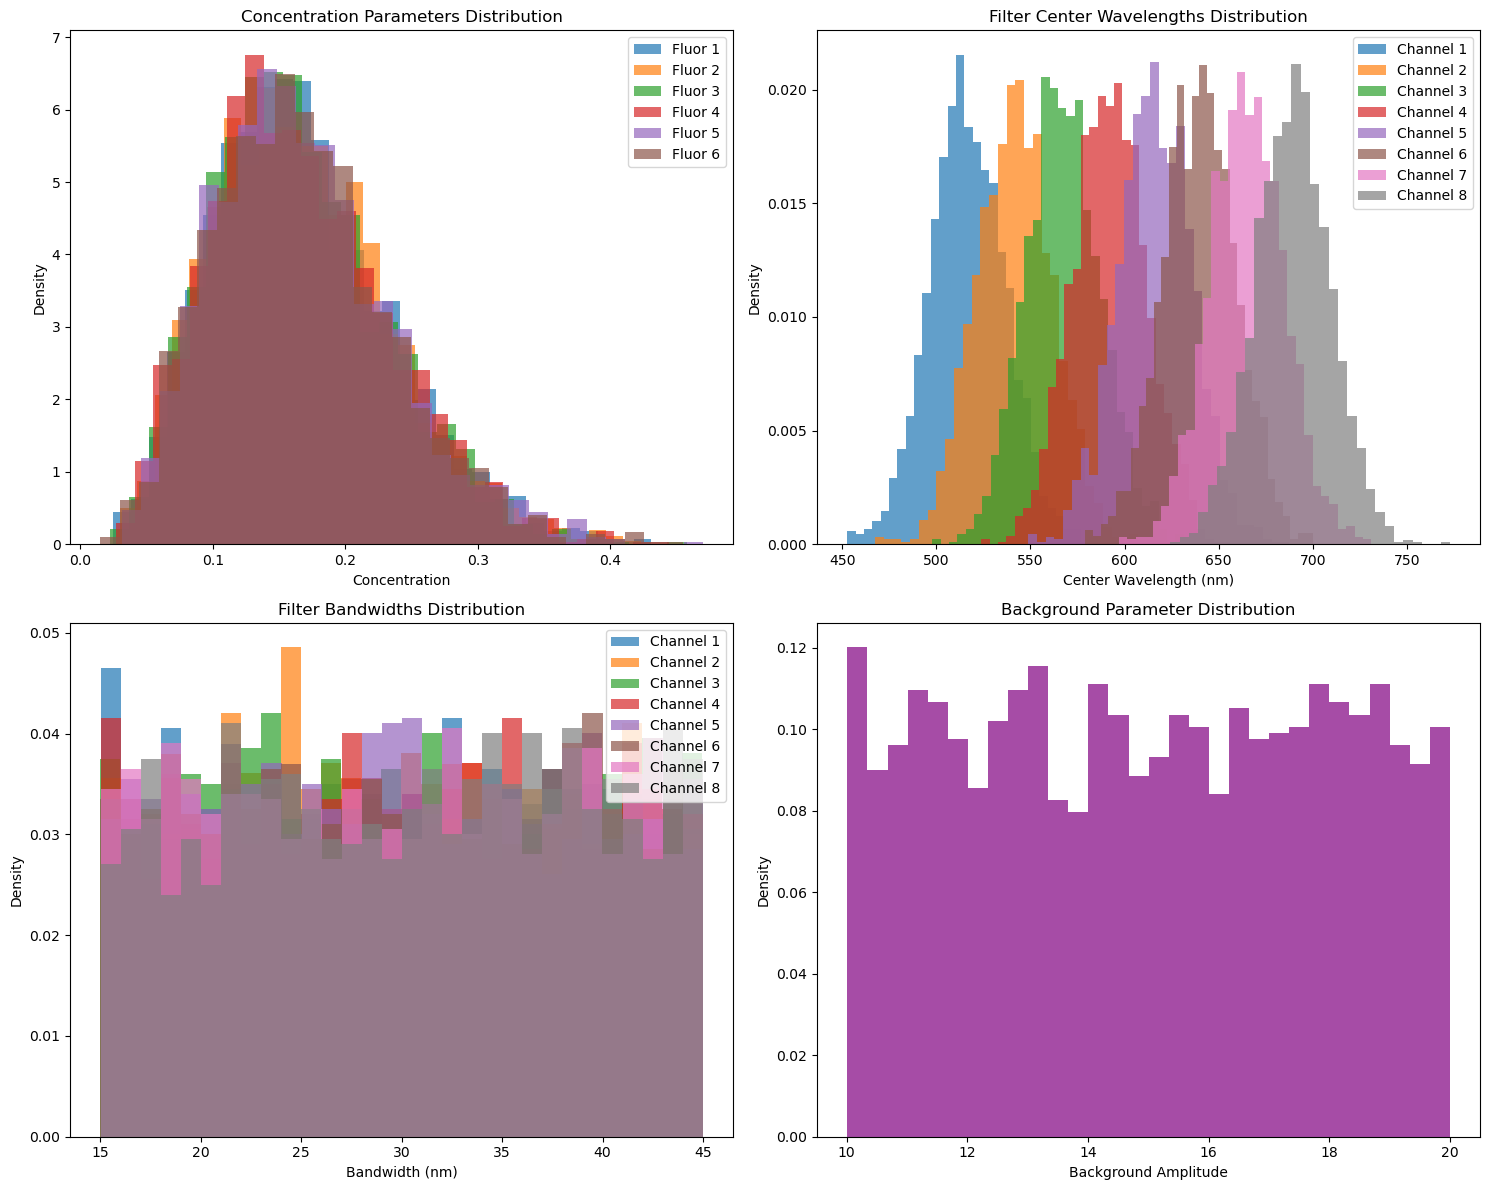

In [10]:
# Plot prior distributions
fig1 = visualizer.plot_prior_distributions(n_samples=2000, figsize=(15, 12))
plt.show()

## 5. Visualize Parameter Correlations

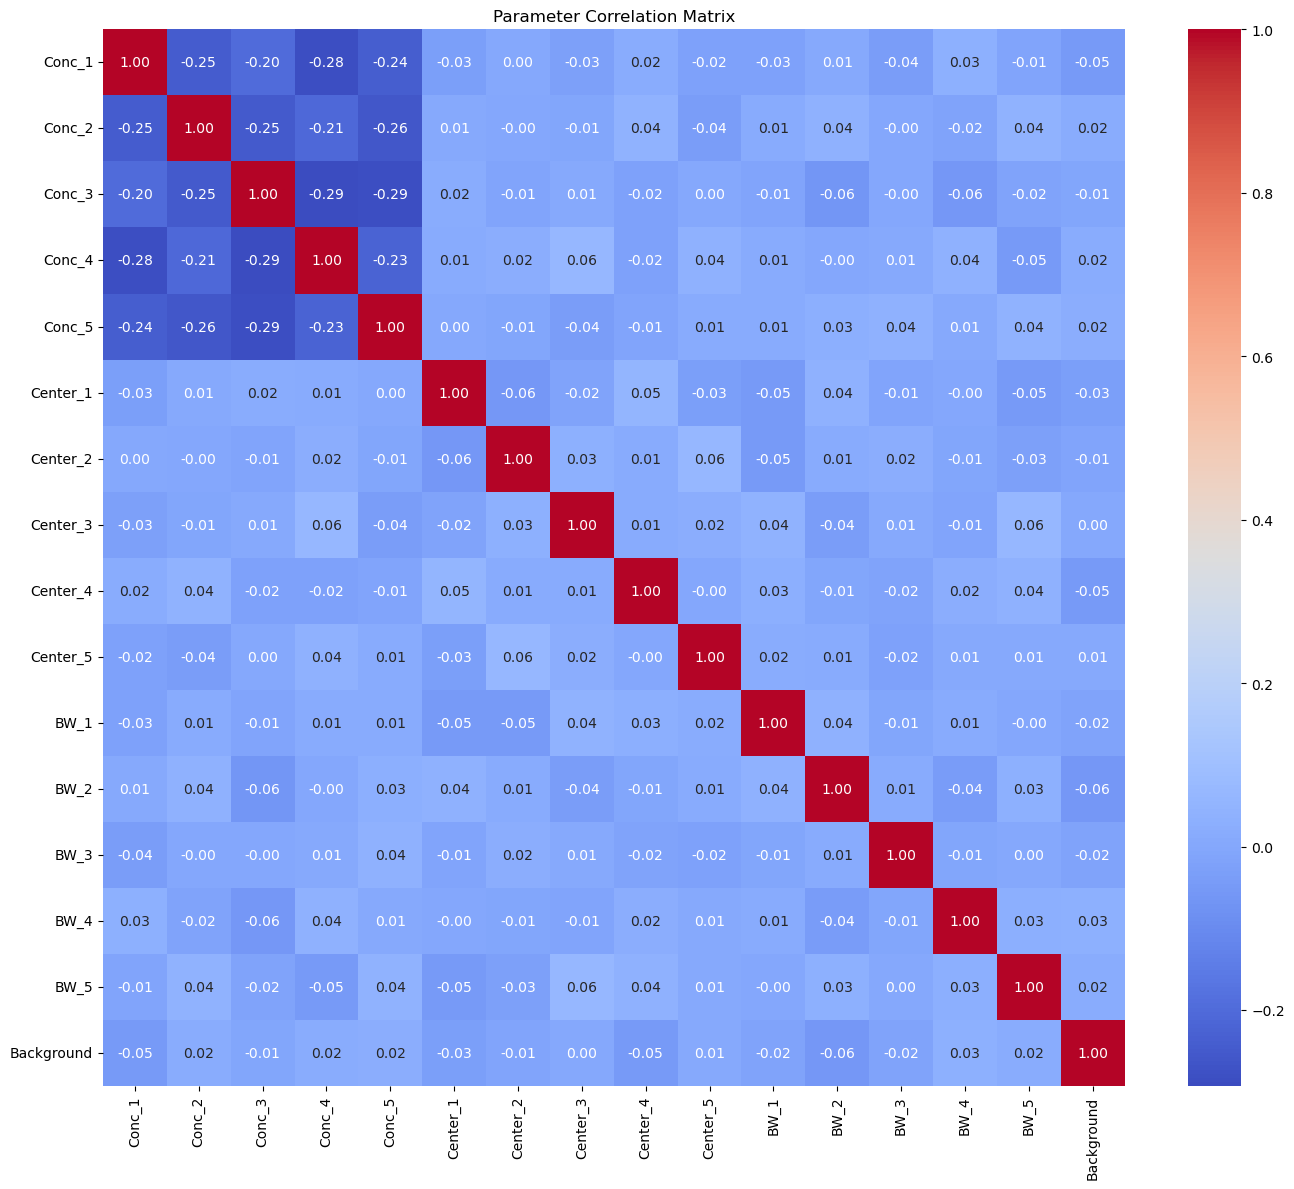

In [30]:
# Plot correlation matrix
fig2 = visualizer.plot_parameter_correlations(n_samples=1000, figsize=(14, 12))
plt.show()

## 6. Explore Filter Configuration Space

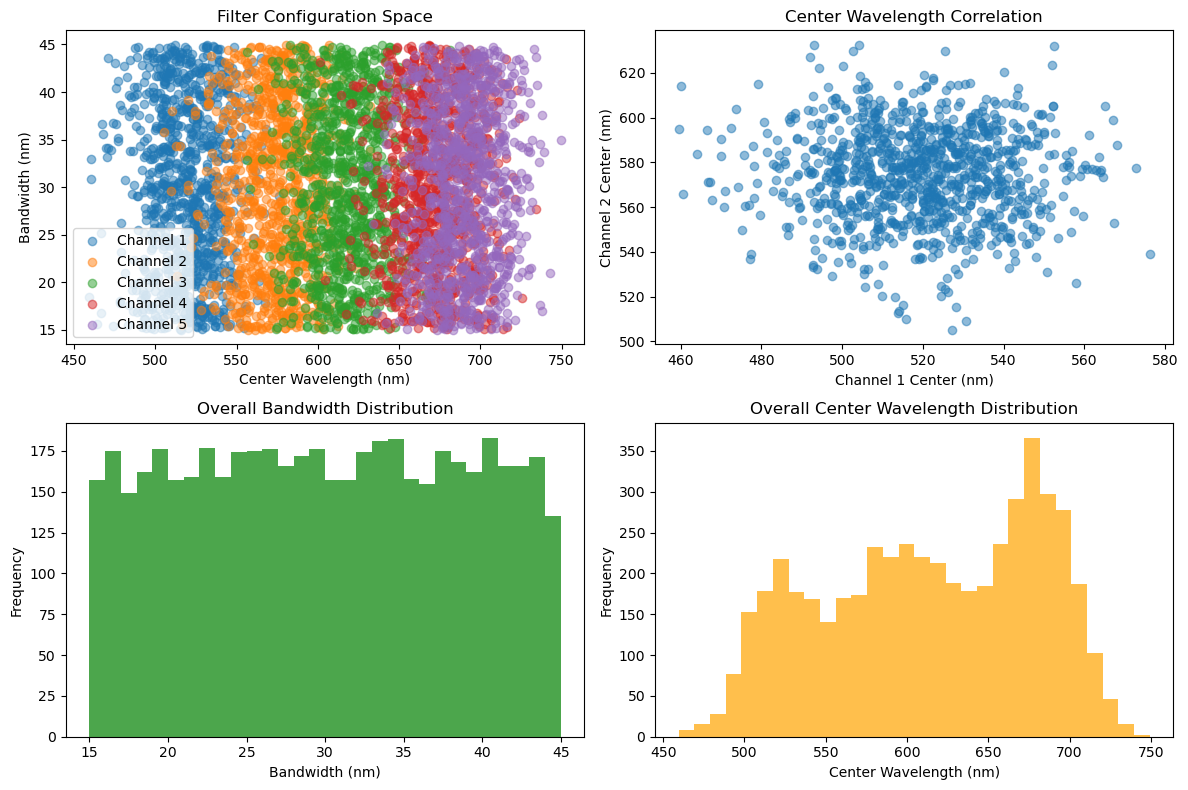

In [31]:
# Plot filter configuration space
fig3 = visualizer.plot_filter_configuration_space(n_samples=1000, figsize=(12, 8))
plt.show()

## 7. Generate Training Data

In [32]:
# Generate training data for SBI
n_training = 10000
theta, x = simulator.generate_training_data(
    n_samples=n_training,
    prior_config=prior_config,
    use_custom_prior=True
)

print(f"Generated {n_training} training samples")
print(f"Parameters shape: {theta.shape}")
print(f"Observations shape: {x.shape}")

# Extract parameters from training data
train_params = prior.extract_parameters(theta)
print("\nTraining parameter statistics:")
for key, value in train_params.items():
    print(f"{key}: mean={value.mean():.3f}, std={value.std():.3f}")

Generated 10000 training samples
Parameters shape: torch.Size([10000, 16])
Observations shape: torch.Size([10000, 5])

Training parameter statistics:
concentrations: mean=0.200, std=0.079
center_wavelengths: mean=614.731, std=65.427
bandwidths: mean=30.022, std=8.673
background: mean=14.973, std=2.897


/groups/spruston/home/moharb/sbi-DELTA/notebooks/../multiplex_sim/sbi_simulator_with_filters.py:592: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(results, dtype=torch.float32)


## 8. Advanced Prior Configuration

In [19]:
config_dict

'concentration'

In [18]:
prior_config

{'concentration': 1.5,
 'center_low': 520,
 'center_high': 780,
 'bandwidth_low': 15,
 'bandwidth_high': 45,
 'background_low': 10.0,
 'background_high': 100.0}

In [23]:
config_dict

'concentration'

In [25]:
configs[0]

{'concentration': 0.5, 'name': 'Sparse concentrations'}

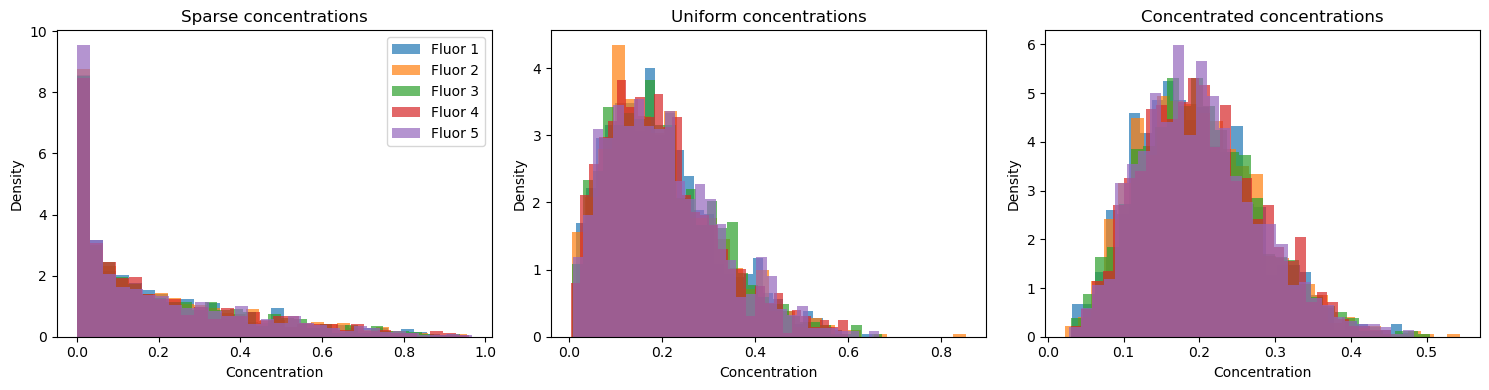

In [33]:
# Example: Different prior configurations
configs = [
    {"concentration": 0.5, "name": "Sparse concentrations"},
    {"concentration": 2.0, "name": "Uniform concentrations"},
    {"concentration": 5.0, "name": "Concentrated concentrations"}
]

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i, (config_dict) in enumerate(configs):
    temp_prior = simulator.create_custom_prior(prior_config={**prior_config, **config_dict})
    samples = temp_prior.sample((1000,))
    concentrations = temp_prior.extract_parameters(samples)['concentrations']
    
    # Plot concentration distribution
    for j in range(concentrations.shape[1]):
        axes[i].hist(concentrations[:, j], bins=30, alpha=0.7, label=f'Fluor {j+1}', density=True)
    axes[i].set_title(config_dict['name'])
    axes[i].set_xlabel('Concentration')
    axes[i].set_ylabel('Density')
    if i == 0:
        axes[i].legend()

plt.tight_layout()
plt.show()

## 9. Save and Load Configuration

In [ ]:
# Save configuration for later use
import json

config_dict = {
    'fluorophore_names': fluorophore_names,
    'n_channels': config.n_channels,
    'prior_config': prior_config,
    'total_params': simulator.total_params
}

with open('enhanced_sbi_config.json', 'w') as f:
    json.dump(config_dict, f, indent=2)

print("Configuration saved to enhanced_sbi_config.json")

# Load configuration
with open('enhanced_sbi_config.json', 'r') as f:
    loaded_config = json.load(f)

print("Loaded configuration:")
for key, value in loaded_config.items():
    print(f"{key}: {value}")

## Summary

This notebook demonstrated:

1. **Enhanced SBI Simulator**: Extended with background parameters
2. **Custom Flat Prior**: Unified prior for all parameter types
3. **Prior Visualization**: Comprehensive plotting tools for parameter exploration
4. **Parameter Extraction**: Easy access to individual parameter groups
5. **Training Data Generation**: Seamless integration with SBI workflows

The enhanced simulator now supports:
- Concentration parameters (Dirichlet prior)
- Filter center wavelengths (Uniform prior)
- Filter bandwidths (Uniform prior)
- Background amplitude (Uniform prior)
- Custom prior configuration
- Comprehensive visualization tools